In [1]:
import sys
import os
import argparse
import logging
import json
import time

import numpy as np
import torch
import pickle
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import BCEWithLogitsLoss, BCELoss ,CrossEntropyLoss
from torch.optim import SGD
from torchvision import models
from torch import nn

from tqdm import tqdm
from tensorboardX import SummaryWriter
from imagedataset import ImageDataset, WSIimageDataset, GradeImageDataset, tumorImageDataset
from testloader import WSIimageDatasetpredict
from clsmodels.models import create_model
from clsmodels import resnet_fpn,senet_fpn
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_recall_curve,average_precision_score
from testloader import WSIimageDatasetpredict,WSIimageDatasetpredict2
from clsmodels import resnet_fpn_sf,senet_fpn_sf
from clsmodels import efficientdet_sf
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split

Duplicate key in file PosixPath('/home/yinxiaoxu/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 252 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/yinxiaoxu/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 260 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/yinxiaoxu/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 403 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [2]:
## 训练集测试集列表，通用的
slist = np.load('fin.npy')
with open('cellfeaturesn.json','r') as f:
    cf = json.load(f)
slidelist = []
for slide in slist:
    if slide in cf:
        slidelist.append(slide)

i = 0
with open('dataconfig/rateall.json','r') as f:
    cf = json.load(f)
slidelist1 = []
for slide in slist:
    if slide in cf:
        slidelist1.append(slide)

testslide = np.load('testslide.npy')

In [3]:
bs = 32

## metric

### nf、ncr、shape

In [5]:
# 生成dataset
with open('dataconfig/rateall.json','r') as f:
    samplerate = json.load(f)

traindataset = ImageDataset(slidelist1,512,1,samplerate,True)                            
traindataloader = DataLoader(traindataset,batch_size = bs)

with open('dataconfig/rateval_all.json','r') as f:
    samplerate = json.load(f)

valdataset = ImageDataset(testslide,512,1,samplerate,False)                            
valdataloader = DataLoader(valdataset,batch_size = bs)
classnum = 2

In [75]:
##CNN式模型
###3个特征得重复利用
#backbone = 'resnet34'
backbone = 'densenet121'
weights = 'temp/checkpoints/ncr/densenet121/densenet121_0_1_best.pth.tar'
model = create_model(backbone,pretrained = True,num_classes=classnum)


create_pretrained_densenet 121


In [90]:
##CNNFPN_sf模型
# weights = 'temp/checkpoints/ncr/resnet34_fpn_classifier/resnet34_fpn_classifier_5_1_best.pth.tar'
# model = resnet_fpn_sf.resnet34_fpn_classifier(num_classes=[2,2,2],pretrained = True)

# weights = 'temp/checkpoints/ncr/se_resnet50_fpn_classifier/se_resnet50_fpn_classifier_10_1_best.pth.tar'
# model = senet_fpn_sf.se_resnet50_fpn_classifier(num_classes=[2,2,2])

weights = 'temp/checkpoints/ncr/efficientnet_bifpn_classifier/efficientnet_bifpn_classifier_22_1_best.pth.tar'
model = efficientdet_sf.EfficientDetBackbone(num_classes=[2,2,2])

In [91]:
#研究一下dataparallel
model = torch.nn.DataParallel(model)
model = model.cuda()

model.load_state_dict(torch.load(weights))
#loss_fn = CrossEntropyLoss().cuda()
loss_fn = BCEWithLogitsLoss().cuda()
#optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay = 5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=10,verbose=True)

In [92]:
# 注意，记得改label的索引
model.eval()
#model.module.freeze_bn()
ALPHA = 0.5
print('Num training images: {}'.format(len(valdataset)))
with torch.no_grad():
    model.eval()
    epoch_loss_val = []
    loss_val = []
    acc_val = []
    preds = []
    trues = []
    probs = []

    progress_bar = tqdm(enumerate(valdataloader),total = len(valdataloader))
    for iter_num,data in progress_bar:
        img,label1,label2,label3 = data
        img = img.cuda().float()
        label = label2.cuda().float()
        output = model(img)

        output = torch.squeeze(output)
        #output2 = torch.squeeze(output2)
        
        prob = output.sigmoid()
        
        loss = loss_fn(output,label)
        #loss_shape = loss_fn(output2,label_shape)

        #loss = loss_nf + ALPHA*loss_shape

        pred = output.argmax(axis=1)
        #pred_shape = output2.argmax(axis=1)

        #print(pred_shape)
        #print(label_shape.argmax(axis=1))

        acc = (pred == label.argmax(axis=1)).sum().data * 1.0/32
        #acc_shape = (pred_shape == label_shape.argmax(axis=1)).sum().data * 1.0/32

        loss_val.append(float(loss))
        #loss_cls2_val.append(float(loss_shape))
        #epoch_loss_val.append(float(loss))
        acc_val.append(float(acc))
        #acc_cls2_val.append(float(acc_shape))
        preds.extend(np.array(pred.cpu()).tolist())
        #pred2.extend(np.array(pred_shape.cpu()).tolist())
        trues.extend(np.array(label.argmax(axis=1).cpu()).tolist())
        #true2.extend(np.array(label_shape.argmax(axis=1).cpu()).tolist())
        probs.extend(np.array(prob[:,1].cpu()).tolist())

        progress_bar.set_description(
            f'cls_nf: {np.mean(loss_val):1.4f} acc_nf: {np.mean(acc_val):1.4f}')

  0%|          | 0/75 [00:00<?, ?it/s]

Num training images: 2390


cls_nf: 0.4895 acc_nf: 0.8179: 100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


In [93]:
# 单特征结果
cm = confusion_matrix(trues,preds,labels = [1,0])
TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+FP+FN+TN)
f1_score = 2*precision*recall/(precision+recall)

print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')

pre:0.8541,rec:0.8041,spe:0.8413,acc:0.8213,f1-score:0.8283


In [74]:
bl_nf = {}
bl_nf['label'] = trues
bl_nf['prob'] = probs

In [79]:
## roc曲线
dense_nf = {}
dense_nf['label'] = trues
dense_nf['prob'] = probs

In [84]:
resfpnsf_nf = {}
resfpnsf_nf['label'] = trues
resfpnsf_nf['prob'] = probs

In [89]:
seresfpnsf_nf = {}
seresfpnsf_nf['label'] = trues
seresfpnsf_nf['prob'] = probs

In [94]:
eff_nf = {}
eff_nf['label'] = trues
eff_nf['prob'] = probs

In [6]:
## CNNFPN
model = resnet_fpn.resnet34_fpn_classifier(num_classes=[2,2,2],pretrained = True)
#model = senet_fpn.se_resnet50_fpn_classifier(num_classes=[2,2,2])
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('temp/checkpoints/resnet34_fpn_classifier/resnet34_fpn_classifier_42_shape_1_best.pth.tar'))
#model.load_state_dict(torch.load('temp/checkpoints/resnet34_fpn_classifier/resnet34_fpn_classifier_6_nf_1_best.pth.tar'))
#model.load_state_dict(torch.load('temp/checkpoints/resnet34_fpn_classifier/resnet34_fpn_classifier_21_shape_1_best.pth.tar'))

loss_fn = BCEWithLogitsLoss().cuda()

In [7]:
model.eval()
#model.module.freeze_bn()
ALPHA = 0.5
print('Num training images: {}'.format(len(valdataset)))
with torch.no_grad():
    model.eval()
    epoch_loss_val = []
    loss_cls1_val = []
    loss_cls2_val = []
    acc_cls1_val = []
    acc_cls2_val = []
    acc_cls3_val = []
    pred1 = []
    pred2 = []
    pred3 = []
    true1 = []
    true2 = []
    true3 = []
    probs1 = []
    probs2 = []
    probs3 = []

    progress_bar = tqdm(enumerate(valdataloader),total = len(valdataloader))
    for iter_num,data in progress_bar:
        img, label_nf,label_ncr,label_shape = data
        img = img.cuda().float()
        label_nf = label_nf.cuda().float()
        label_ncr = label_ncr.cuda().float()
        label_shape = label_shape.cuda().float()
        output1,output2,output3 = model(img)

        output1 = torch.squeeze(output1)
        output2 = torch.squeeze(output2)
        output3 = torch.squeeze(output3)
        
        prob1 = output1.sigmoid()
        prob2 = output2.sigmoid()
        prob3 = output3.sigmoid()
        
        loss_nf = loss_fn(output1,label_nf)
        #loss_shape = loss_fn(output2,label_shape)

        #loss = loss_nf + ALPHA*loss_shape

        pred_nf = output1.argmax(axis=1)
        pred_ncr = output2.argmax(axis=1)
        pred_shape = output3.argmax(axis=1)

        #print(pred_shape)
        #print(label_shape.argmax(axis=1))

        acc_nf = (pred_nf == label_nf.argmax(axis=1)).sum().data * 1.0/32
        acc_ncr = (pred_ncr == label_ncr.argmax(axis=1)).sum().data * 1.0/32
        acc_shape = (pred_shape == label_shape.argmax(axis=1)).sum().data * 1.0/32

        loss_cls1_val.append(float(loss_nf))
        #loss_cls2_val.append(float(loss_shape))
        #epoch_loss_val.append(float(loss))
        acc_cls1_val.append(float(acc_nf))
        acc_cls2_val.append(float(acc_ncr))
        acc_cls3_val.append(float(acc_shape))
        pred1.extend(np.array(pred_nf.cpu()).tolist())
        pred2.extend(np.array(pred_ncr.cpu()).tolist())
        pred3.extend(np.array(pred_shape.cpu()).tolist())
        true1.extend(np.array(label_nf.argmax(axis=1).cpu()).tolist())
        true2.extend(np.array(label_ncr.argmax(axis=1).cpu()).tolist())
        true3.extend(np.array(label_shape.argmax(axis=1).cpu()).tolist())
        probs1.extend(np.array(prob1[:,1].cpu()).tolist())
        probs2.extend(np.array(prob2[:,1].cpu()).tolist())
        probs3.extend(np.array(prob3[:,1].cpu()).tolist())


        progress_bar.set_description(
            f'cls_nf: {np.mean(loss_cls1_val):1.4f} acc_nf: {np.mean(acc_cls1_val):1.4f} acc_ncr: {np.mean(acc_cls2_val):1.4f} acc_shape: {np.mean(acc_cls3_val):1.4f}')


  0%|          | 0/75 [00:00<?, ?it/s]

Num training images: 2390


cls_nf: 0.5694 acc_nf: 0.7683 acc_ncr: 0.8325 acc_shape: 0.9163: 100%|██████████| 75/75 [00:57<00:00,  1.30it/s]


In [52]:
cm = confusion_matrix(true3,pred3,labels = [1,0])
TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+FP+FN+TN)
f1_score = 2*precision*recall/(precision+recall)

print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')

pre:0.9137,rec:0.8739,spe:0.9526,acc:0.9238,f1-score:0.8933


In [8]:
resfc_nf = {}
resfc_nf['label'] = true1
resfc_nf['prob'] = probs1
resfc_ncr = {}
resfc_ncr['label'] = true2
resfc_ncr['prob'] = probs2
resfc_shape = {}
resfc_shape['label'] = true3
resfc_shape['prob'] = probs3

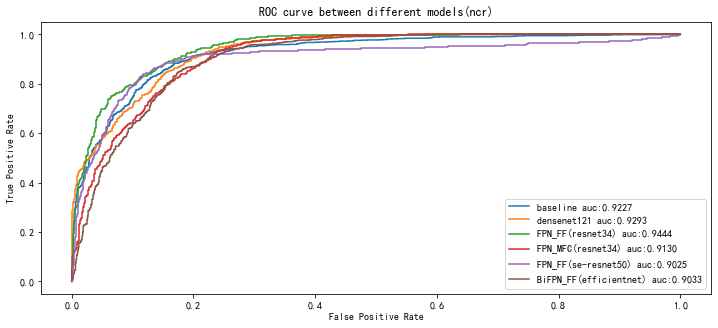

In [95]:
### ROC
plt.figure(figsize=(12,5))
fprbl, tprbl, thresholdbl = roc_curve(bl_nf['label'],bl_nf['prob'])
roc_aucbl = auc(fprbl,tprbl)
plt.plot(fprbl, tprbl)

fprde, tprde, thresholdde = roc_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = auc(fprde,tprde)
plt.plot(fprde, tprde)

fprfc, tprfc, thresholdfc = roc_curve(resfpnsf_nf['label'],resfpnsf_nf['prob'])
roc_aucfc = auc(fprfc,tprfc)
plt.plot(fprfc, tprfc)

fprfpn, tprfpn, thresholdfpn = roc_curve(resfc_ncr['label'],resfc_ncr['prob'])
roc_aucfpn = auc(fprfpn,tprfpn)
plt.plot(fprfpn, tprfpn)

fprsefpn, tprsefpn, thresholdsefpn = roc_curve(seresfpnsf_nf['label'],seresfpnsf_nf['prob'])
roc_aucsefpn = auc(fprsefpn,tprsefpn)
plt.plot(fprsefpn, tprsefpn)

fpreff, tpreff, thresholdeff = roc_curve(eff_nf['label'],eff_nf['prob'])
roc_auceff = auc(fpreff,tpreff)
plt.plot(fpreff, tpreff)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'baseline auc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'FPN_FF(resnet34) auc:{roc_aucfc:.4f}',f'FPN_MFC(resnet34) auc:{roc_aucfpn:.4f}',f'FPN_FF(se-resnet50) auc:{roc_aucsefpn:.4f}',f'BiFPN_FF(efficientnet) auc:{roc_auceff:.4f}'])
plt.title('ROC curve between different models(ncr)')
#plt.savefig('roc_curve_ncr.png')
plt.show()

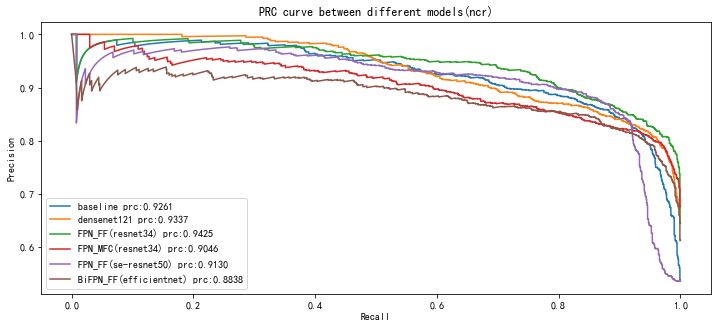

In [96]:
#tempp = eff_nf['prob']
#eff_nf['prob'] = 1-np.array(eff_nf['prob'])
### PRC
plt.figure(figsize=(12,5))
prebl, recbl, thresholdbl = precision_recall_curve(bl_nf['label'],bl_nf['prob'])
roc_aucbl = average_precision_score(bl_nf['label'],bl_nf['prob'])
plt.plot(recbl, prebl)

prede, recde, thresholdbl = precision_recall_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = average_precision_score(dense_nf['label'],dense_nf['prob'])
plt.plot(recde, prede)

prefc, recfc, thresholdbl = precision_recall_curve(resfpnsf_nf['label'],resfpnsf_nf['prob'])
roc_aucfc = average_precision_score(resfpnsf_nf['label'],resfpnsf_nf['prob'])
plt.plot(recfc, prefc)

prefpn, recfpn, thresholdbl = precision_recall_curve(resfc_ncr['label'],resfc_ncr['prob'])
roc_aucfpn = average_precision_score(resfc_ncr['label'],resfc_ncr['prob'])
plt.plot(recfpn, prefpn)

presefpn, recsefpn, thresholdfpn = precision_recall_curve(seresfpnsf_nf['label'],seresfpnsf_nf['prob'])
roc_aucsefpn = average_precision_score(seresfpnsf_nf['label'],seresfpnsf_nf['prob'])
plt.plot(recsefpn, presefpn)

preeff, receff, thresholdeff = precision_recall_curve(eff_nf['label'],eff_nf['prob'])
roc_auceff = average_precision_score(eff_nf['label'],eff_nf['prob'])
plt.plot(receff, preeff)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([f'baseline prc:{roc_aucbl:.4f}',f'densenet121 prc:{roc_aucde:.4f}',f'FPN_FF(resnet34) prc:{roc_aucfc:.4f}',f'FPN_MFC(resnet34) prc:{roc_aucfpn:.4f}',f'FPN_FF(se-resnet50) prc:{roc_aucsefpn:.4f}',f'BiFPN_FF(efficientnet) prc:{roc_auceff:.4f}'])
plt.title('PRC curve between different models(ncr)')
#plt.savefig('prc_curve_nf.png')
plt.show()

In [ ]:
seresfpn_ncr['prob'] = 1-np.array(seresfpn_ncr['prob'])
### ROC
plt.figure(figsize=(12,5))
fprbl, tprbl, thresholdbl = roc_curve(bl_ncr['label'],bl_ncr['prob'])
roc_aucbl = auc(fprbl,tprbl)
plt.plot(fprbl, tprbl)

fprde, tprde, thresholdde = roc_curve(dense_ncr['label'],dense_ncr['prob'])
roc_aucde = auc(fprde,tprde)
plt.plot(fprde, tprde)

fprfc, tprfc, thresholdfc = roc_curve(resfpnsf_nf['label'],resfpnsf_nf['prob'])
roc_aucfc = auc(fprfc,tprfc)
plt.plot(fprfc, tprfc)

# fprfpn, tprfpn, thresholdfpn = roc_curve(resfpn_nf['label'],resfpn_nf['prob'])
# roc_aucfpn = auc(fprfpn,tprfpn)
# plt.plot(fprfpn, tprfpn)

fprsefpn, tprsefpn, thresholdsefpn = roc_curve(seresfpn_ncr['label'],seresfpn_ncr['prob'])
roc_aucsefpn = auc(fprsefpn,tprsefpn)
plt.plot(fprsefpn, tprsefpn)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'baseline auc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'MF_resnet34 auc:{roc_aucfc:.4f}',f'FMF_se-resnet50 auc:{roc_aucsefpn:.4f}'])
plt.title('ROC curve between different models(ncr)')
#plt.savefig('roc_curve_ncr.png')
plt.show()

In [ ]:
### PRC
plt.figure(figsize=(12,5))
prebl, recbl, thresholdbl = precision_recall_curve(bl_ncr['label'],bl_ncr['prob'])
roc_aucbl = average_precision_score(bl_ncr['label'],bl_ncr['prob'])
plt.plot(recbl, prebl)

prede, recde, thresholdbl = precision_recall_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = average_precision_score(dense_nf['label'],dense_nf['prob'])
plt.plot(recde, prede)

prefc, recfc, thresholdbl = precision_recall_curve(resfc_ncr['label'],resfc_ncr['prob'])
roc_aucfc = average_precision_score(resfc_ncr['label'],resfc_ncr['prob'])
plt.plot(recfc, prefc)

# prefpn, recfpn, thresholdbl = precision_recall_curve(resfpn_nf['label'],resfpn_nf['prob'])
# roc_aucfpn = average_precision_score(resfpn_nf['label'],resfpn_nf['prob'])
# plt.plot(recfpn, prefpn)

presefpn, recsefpn, thresholdfpn = precision_recall_curve(seresfpn_ncr['label'],seresfpn_ncr['prob'])
roc_aucsefpn = average_precision_score(seresfpn_ncr['label'],seresfpn_ncr['prob'])
plt.plot(recsefpn, presefpn)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([f'baseline prc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'MF_resnet34 prc:{roc_aucfc:.4f}',f'FMF_se-resnet50 prc:{roc_aucsefpn:.4f}'])
plt.title('PRC curve between different models(nf)')
plt.savefig('prc_curve_ncr.png')
plt.show()

In [ ]:
#混淆矩阵最后可以看看grade的，其他没必要

### nec、envelop

In [28]:
mission = 'necrosis'
#mission = 'envelop'
bs = 32

In [29]:
traindataset = WSIimageDataset(is_training = True,
                                mission = mission)
# num_workers
traindataloader = DataLoader(traindataset,batch_size = bs)
valdataset = WSIimageDataset(is_training = False,
                                mission = mission)
# num_workers
valdataloader = DataLoader(valdataset,batch_size = bs)
classnum = 2

In [30]:
## 只用resnet18看看就行了，效果很行
backbone = 'resnet18'
weights = 'temp/checkpoints/necrosis/resnet18/resnet18_59_best.pth.tar'
#weights = 'temp/checkpoints/envelop/resnet18/resnet18_34.pth.tar'
model = create_model(backbone,pretrained = True,num_classes=classnum)

model = torch.nn.DataParallel(model)
model = model.cuda()

loss_fn = BCEWithLogitsLoss().cuda()
model.load_state_dict(torch.load(weights))

create_pretrained_resnet 18
creating resnet18, pretrained: True


<All keys matched successfully>

In [31]:
with torch.no_grad():
    model.eval()
    epoch_loss_val = []
    epoch_acc_val = []
    preds = []
    trues = []
    probs = []


    progress_bar = tqdm(valdataloader)
    for imgs,label in progress_bar:
        imgs = imgs.float().cuda()
        label = label.float().cuda()

        output = model(imgs)

        output = torch.squeeze(output)
        #loss = loss_fn(output,label.argmax(axis=1))
        loss = loss_fn(output,label)

        prob = output.sigmoid()
        pred = output.argmax(axis=1)

        #print(label.argmax(axis=1))
        #print(pred)

        acc_data = (pred == label.argmax(axis=1)).sum().data * 1.0/bs
        loss_data = loss.data

        epoch_loss_val.append(float(loss_data))
        epoch_acc_val.append(float(acc_data))
        
        preds.extend(np.array(pred.cpu()).tolist())
        #pred2.extend(np.array(pred_shape.cpu()).tolist())
        trues.extend(np.array(label.argmax(axis=1).cpu()).tolist())
        #true2.extend(np.array(label_shape.argmax(axis=1).cpu()).tolist())
        probs.extend(np.array(prob[:,1].cpu()).tolist())

        progress_bar.set_description(
            f'val:loss: {np.mean(epoch_loss_val):1.4f} acc_all: {np.mean(epoch_acc_val):1.4f}')

val:loss: 0.1058 acc_all: 0.9598: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [32]:
# 单特征结果
cm = confusion_matrix(trues,preds,labels = [1,0])
TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+FP+FN+TN)
f1_score = 2*precision*recall/(precision+recall)

print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')

pre:0.9587,rec:0.9748,spe:0.9519,acc:0.9641,f1-score:0.9667


In [ ]:
## roc曲线
dense_nf = {}
dense_nf['label'] = trues
dense_nf['prob'] = probs

In [ ]:
### ROC
plt.figure(figsize=(12,5))
fprbl, tprbl, thresholdbl = roc_curve(bl_nf['label'],bl_nf['prob'])
roc_aucbl = auc(fprbl,tprbl)
plt.plot(fprbl, tprbl)

fprde, tprde, thresholdde = roc_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = auc(fprde,tprde)
plt.plot(fprde, tprde)

fprfc, tprfc, thresholdfc = roc_curve(resfc_nf['label'],resfc_nf['prob'])
roc_aucfc = auc(fprfc,tprfc)
plt.plot(fprfc, tprfc)

fprfpn, tprfpn, thresholdfpn = roc_curve(resfpn_nf['label'],resfpn_nf['prob'])
roc_aucfpn = auc(fprfpn,tprfpn)
plt.plot(fprfpn, tprfpn)

fprsefpn, tprsefpn, thresholdsefpn = roc_curve(seresfpn_nf['label'],seresfpn_nf['prob'])
roc_aucsefpn = auc(fprsefpn,tprsefpn)
plt.plot(fprsefpn, tprsefpn)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'baseline auc:{roc_aucbl:.4f}',f'densenet121 auc:{roc_aucde:.4f}',f'MF_resnet34 auc:{roc_aucfc:.4f}',f'FMF_resnet34 auc:{roc_aucfpn:.4f}',f'FMF_se-resnet50 auc:{roc_aucsefpn:.4f}'])
plt.title('ROC curve between different models(nf)')
plt.savefig('roc_curve_nf.png')
plt.show()

In [ ]:
### PRC
plt.figure(figsize=(12,5))
prebl, recbl, thresholdbl = precision_recall_curve(bl_nf['label'],bl_nf['prob'])
roc_aucbl = average_precision_score(bl_nf['label'],bl_nf['prob'])
plt.plot(recbl, prebl)

prede, recde, thresholdbl = precision_recall_curve(dense_nf['label'],dense_nf['prob'])
roc_aucde = average_precision_score(dense_nf['label'],dense_nf['prob'])
plt.plot(recde, prede)

prefc, recfc, thresholdbl = precision_recall_curve(resfc_nf['label'],resfc_nf['prob'])
roc_aucfc = average_precision_score(resfc_nf['label'],resfc_nf['prob'])
plt.plot(recfc, prefc)

prefpn, recfpn, thresholdbl = precision_recall_curve(resfpn_nf['label'],resfpn_nf['prob'])
roc_aucfpn = average_precision_score(resfpn_nf['label'],resfpn_nf['prob'])
plt.plot(recfpn, prefpn)

presefpn, recsefpn, thresholdfpn = precision_recall_curve(seresfpn_nf['label'],seresfpn_nf['prob'])
roc_aucsefpn = average_precision_score(seresfpn_nf['label'],seresfpn_nf['prob'])
plt.plot(recsefpn, presefpn)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend([f'baseline prc:{roc_aucbl:.4f}',f'densenet121 prc:{roc_aucde:.4f}',f'MF_resnet34 prc:{roc_aucfc:.4f}',f'FMF_resnet34 prc:{roc_aucfpn:.4f}',f'FMF_se-resnet50 prc:{roc_aucsefpn:.4f}'])
plt.title('PRC curve between different models(nf)')
plt.savefig('prc_curve_nf.png')
plt.show()

### grade

In [23]:
bs = 32

In [24]:
#patch级的
with open('dataconfig/rate_level2.json','r') as f:
    samplerate = json.load(f)
traindataset = GradeImageDataset(slidelist1,256,2,samplerate,True)                            
traindataloader = DataLoader(traindataset,batch_size = bs)

with open('dataconfig/rateval_all.json','r') as f:
    samplerate = json.load(f)

valdataset = GradeImageDataset(testslide,256,2,samplerate,False)                            
valdataloader = DataLoader(valdataset,batch_size = bs)
classnum = 3

In [26]:
backbone = 'resnet34'
weights = 'temp/checkpoints/grade/resnet34/resnet34_43_best.pth.tar'
#weights = 'temp/checkpoints/envelop/resnet18/resnet18_34.pth.tar'
model = create_model(backbone,pretrained = True,num_classes=classnum)

model = torch.nn.DataParallel(model)
model = model.cuda()

loss_fn = BCEWithLogitsLoss().cuda()
model.load_state_dict(torch.load(weights))

create_pretrained_resnet 34
creating resnet34, pretrained: True


<All keys matched successfully>

In [29]:
with torch.no_grad():
    model.eval()
    epoch_loss_val = []
    epoch_acc_val = []
    preds = []
    trues = []
    probs = []

    progress_bar = tqdm(valdataloader)
    for imgs,label in progress_bar:
        imgs = imgs.float().cuda()
        label = label.float().cuda()

        output = model(imgs)

        output = torch.squeeze(output)
        #loss = loss_fn(output,label.argmax(axis=1))
        loss = loss_fn(output,label)

        prob = output.sigmoid()
        pred = output.argmax(axis=1)

        #print(label.argmax(axis=1))
        #print(pred)

        acc_data = (pred == label.argmax(axis=1)).sum().data * 1.0/bs
        loss_data = loss.data

        epoch_loss_val.append(float(loss_data))
        epoch_acc_val.append(float(acc_data))
        preds.extend(np.array(pred.cpu()).tolist())
        #pred2.extend(np.array(pred_shape.cpu()).tolist())
        trues.extend(np.array(label.argmax(axis=1).cpu()).tolist())
        #true2.extend(np.array(label_shape.argmax(axis=1).cpu()).tolist())
        probs.extend(np.array(prob[:,1].cpu()).tolist())

        progress_bar.set_description(
            f'val:  loss: {np.mean(epoch_loss_val):1.4f} acc_all: {np.mean(epoch_acc_val):1.4f}')

        del loss
    results['loss_val'].append(np.mean(epoch_loss_val))
    results['acc_val'].append(np.mean(epoch_acc_val))

val:  loss: 0.2814 acc_all: 0.8367: 100%|██████████| 75/75 [02:50<00:00,  2.27s/it]


NameError: name 'results' is not defined

In [30]:
# 其他同上
cm = confusion_matrix(trues,preds,labels = [1,0])
TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
specifity = TN/(TN+FP)
accuracy = (TP+TN)/(TP+FP+FN+TN)
f1_score = 2*precision*recall/(precision+recall)

print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')

pre:0.8002,rec:0.9477,spe:0.8038,acc:0.8690,f1-score:0.8677


## predict(slide级别)

In [ ]:
# 需要保证验证集patch一样吗？
testslide = np.load('testslide.npy')
slidelist2 = testslide

# 多全连接层
model = resnet_fpn.resnet34_fpn_classifier(num_classes=[2,2,2],pretrained = True)
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load('temp/checkpoints/nf/'))
loss_fn = CrossEntropyLoss().cuda()
model.eval()

preds_nf = np.zeros(len(slidelist2))
preds_ncr = np.zeros(len(slidelist2))
preds_shape = np.zeros(len(slidelist2))

for i in range(len(slidelist2)):
    slide = slidelist2[i]
    print(slide)
    testdataset = WSIimageDataset(slide,1)
    testdataloader = DataLoader(testdataset,batch_size = 32,drop_last = True)

    #labels = cf[slide]
    preds1 = []
    preds2 = []
    preds3 = []


    progress_bar = tqdm(enumerate(testdataloader),total = len(testdataloader))
    for iter_num,data in progress_bar:
        img = data
        img = img.cuda().float()
        #label_nf = label_nf.cuda().float()
        #label_shape = label_shape.cuda().float()
        output1,output2,output3 = model(img)

        output1 = torch.squeeze(output1)
        output2 = torch.squeeze(output2)
        output3 = torch.squeeze(output3)


        pred_nf = output1.argmax(axis=1)
        pred_ncr = output2.argmax(axis=1)
        pred_shape = output3.argmax(axis=1)

        #prob2 = output2.sigmoid()

        #print(pred_shape)
        #print(label_shape.argmax(axis=1))

        preds1.extend(np.array(pred_nf.cpu()).tolist())
        preds2.extend(np.array(pred_ncr.cpu()).tolist())
        preds3.extend(np.array(pred_shape.cpu()).tolist())


        progress_bar.set_description(f'test {slide}')

    rate1 = np.sum(preds1)/len(preds1)
    rate2 = np.sum(preds2)/len(preds2)
    rate3 = np.sum(preds3)/len(preds3)
    #print(rate1,rate2,rate3)
    if rate1 > 0.5:
        preds_nf[i] = 1
    if rate2 > 0.5:
        preds_ncr[i] = 1
    if rate3 > 0.5:
        preds_shape[i] = 1
labels_nfname = ['轻度','显著']
labels_ncrname = ['增大','很大']
labels_shapename = ['粗梁实性','粗梁实性和假腺状']

preds_ncr = preds_ncr.astype(np.int)
preds_nf = preds_nf.astype(np.int)
preds_shape = preds_shape.astype(np.int)

In [6]:
# 单特征的，要多跑几次
# 因为dataloder一样，只需要选不同的模型和state即可
# 模型太多，别搞混了
testslide = np.load('testslide2.npy',allow_pickle=True)
slidelist2 = testslide

In [31]:
backbone = 'resnet34'
classnum = 3

weights = 'temp/checkpoints/grade/resnet34/resnet34_43_best.pth.tar'
model = create_model(backbone,pretrained = True,num_classes=classnum)
model = torch.nn.DataParallel(model)
model = model.cuda()

model.load_state_dict(torch.load(weights))
model.eval()
name = 'grade'

create_pretrained_resnet 34
creating resnet34, pretrained: True


In [37]:
backbone = 'resnet34'
classnum = 2

#weights = 'temp/checkpoints/ncr/se_resnet50_fpn_classifier/se_resnet50_fpn_classifier_10_1_best.pth.tar'
#weights = 'temp/checkpoints/nf/se_resnet50_fpn_classifier/se_resnet50_fpn_classifier_25_1_best.pth.tar'
weights = 'temp/checkpoints/shape/se_resnet50_fpn_classifier/se_resnet50_fpn_classifier_17_1_best.pth.tar'
model = senet_fpn_sf.se_resnet50_fpn_classifier(num_classes=[2,2,2])

model = torch.nn.DataParallel(model)
model = model.cuda()

model.load_state_dict(torch.load(weights))
model.eval()
name = 'shape'

In [38]:
#level的也可以搞好像
with torch.no_grad():
    model.eval()
    preds_sf = []
    preds_patch = []

    for i in range(len(slidelist2)):
        slide = slidelist2[i]
        #print(slide)
        testdataset = WSIimageDatasetpredict(slide,1)
        testdataloader = DataLoader(testdataset,batch_size = 32,drop_last = True)
        #labels = cf[slide]
        preds = []
        probs = []


        progress_bar = tqdm(enumerate(testdataloader),total = len(testdataloader))
        for iter_num,data in progress_bar:
            img = data
            img = img.cuda().float()
            #label_nf = label_nf.cuda().float()
            #label_shape = label_shape.cuda().float()
            output = model(img)

            output = torch.squeeze(output)

            pred_sf = output.argmax(axis=1)

            prob = output.sigmoid()

            #print(pred_shape)
            #print(label_shape.argmax(axis=1))

            preds.extend(np.array(pred_sf.cpu()).tolist())
            probs.extend(np.array(prob[:,1].cpu()).tolist())
            progress_bar.set_description(f'test {slide}')

        #rate = np.sum(preds)/len(preds)
        rate = np.sum(probs)/len(probs)
        preds_sf.append(rate)

        preds_patch += preds
        #print(rate1,rate2,rate3)
        #if rate1 > 0.5:
        #    preds_nf[i] = 1
        ## gpu内存不够就得存下来
    savepath = os.path.join('temp/predictions','pred_'+name+'.npy')
    np.save(savepath,preds_sf)
    savepath = os.path.join('temp/predictions','preds_'+name+'.npy')
    np.save(savepath,preds_patch)


test 201630452-4: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


In [104]:
## env
backbone = 'resnet18'
classnum = 2

#weights = 'temp/checkpoints/necrosis/resnet18/resnet18_59_best.pth.tar'
weights = 'temp/checkpoints/envelop/resnet18/resnet18_34.pth.tar'

model = create_model(backbone,pretrained = True,num_classes=classnum)
model = torch.nn.DataParallel(model)
model = model.cuda()

model.load_state_dict(torch.load(weights))
model.eval()
name = 'envelop'

create_pretrained_resnet 18
creating resnet18, pretrained: True


In [105]:
#level的也可以搞好像
with torch.no_grad():
    model.eval()
    preds_sf = []
    preds_patch = []

    for i in range(len(slidelist2)):
        slide = slidelist2[i]
        #print(slide)
        testdataset = WSIimageDatasetpredict2(slide,1)
        testdataloader = DataLoader(testdataset,batch_size = 16)
        #labels = cf[slide]
        preds = []
        probs = []


        progress_bar = tqdm(enumerate(testdataloader),total = len(testdataloader))
        for iter_num,data in progress_bar:
            img = data
            img = img.cuda().float()
            #label_nf = label_nf.cuda().float()
            #label_shape = label_shape.cuda().float()
            output = model(img)

            output = torch.squeeze(output)

            pred_sf = output.argmax(axis=1)

            prob = output.sigmoid()

            #print(pred_shape)
            #print(label_shape.argmax(axis=1))

            preds.extend(np.array(pred_sf.cpu()).tolist())
            probs.extend(np.array(prob[:,1].cpu()).tolist())
            progress_bar.set_description(f'test {slide}')

        rate = np.sum(preds)/len(preds)
        #rate = np.sum(probs)/len(probs)
        preds_sf.append(rate)

        preds_patch += preds
        #print(rate1,rate2,rate3)
        #if rate1 > 0.5:
        #    preds_nf[i] = 1
        ## gpu内存不够就得存下来
    savepath = os.path.join('temp/predictions','pred_'+name+'.npy')
    np.save(savepath,preds_sf)
    savepath = os.path.join('temp/predictions','preds_'+name+'.npy')
    np.save(savepath,preds_patch)

test 201630452-4: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


In [50]:
len(preds_sf)

30

In [10]:
preds_sf

[0.5833333333333334,
 1.0,
 1.0,
 0.7777777777777778,
 0.0,
 0.5555555555555556,
 1.0,
 0.16666666666666666,
 1.0,
 1.0,
 0.0,
 0.8888888888888888,
 0.6666666666666666,
 0.0,
 0.0,
 0.3333333333333333,
 1.0,
 0.5,
 0.4444444444444444,
 0.75,
 0.0,
 0.0,
 1.0,
 0.0,
 0.8888888888888888,
 1.0,
 1.0,
 0.4444444444444444,
 0.0,
 0.0]

In [9]:
pred_nf = np.load('temp/predictions/prob_shape.npy')

In [10]:
with open('cellfeaturesn.json','r') as fp:
    cf = json.load(fp)

In [13]:
cf['201601986-2']

[0, 0, 0, 1, 0, 0]

In [4]:
## 算slide层面的预测正确率
pred_nf = np.load('temp/predictions/pred_nf.npy')
pred_ncr = np.load('temp/predictions/pred_ncr.npy')
pred_shape = np.load('temp/predictions/pred_shape.npy')
pred_nec = np.load('temp/predictions/pred_necrosis.npy')
pred_env= np.load('temp/predictions/pred_envelop.npy')
pred_grade = np.load('temp/predictions/pred_grade.npy')

In [ ]:
# 前五个以0.5为界
# 最后一个有0,1,2三种情况
# 按阈值变成整型计算正确率


In [10]:
nf = np.array([0.6,0.87,0.02,0.95,0.54,0.23,0.6,0.87,0.02,0.95,0.54,0.23,0.1,0.87,0.75,0.69])

In [15]:
nf>0.5

array([ True,  True, False,  True,  True, False,  True,  True, False,
        True,  True, False, False,  True,  True,  True])

In [14]:
a.astype(np.int)

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1])

In [8]:
def compute_slide(clsid,predrate,feats):
    if clsid > 0:
        #pred = predrate>0.7 #nf
        #pred = predrate>0.5 #ncr
        pred = predrate>0.452
        pred = pred.astype(np.int)
        true = feats[:,clsid]
              
        cm = confusion_matrix(true,pred,labels = [1,0])
        TP = cm[0,0]
        FP = cm[1,0]
        FN = cm[0,1]
        TN = cm[1,1]

        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        specifity = TN/(TN+FP)
        accuracy = (TP+TN)/(TP+FP+FN+TN)
        f1_score = 2*precision*recall/(precision+recall)
        
        print(f'pre:{precision:.4f},rec:{recall:.4f},spe:{specifity:.4f},acc:{accuracy:.4f},f1-score:{f1_score:.4f}')
        

    if clsid == 0:
        pred = []
        true = feats[:,0]
        for rate in predrate:
            if rate < 0.9:
                pred.append(0)
            if rate>=0.9 and rate<1.4:
                pred.append(1)
            if rate >= 1.4:
                pred.append(2)
        cm = confusion_matrix(true,pred,labels = [0,1,2])
        pred = np.array(pred)
        acc = np.sum(pred == true) * 1.0/16
        print(f'acc: {acc}')
        #可尝试画画混淆函数
        return cm

In [9]:
# 读取label
clsindex = {'grade':0,'nf':1,'ncr':2,'shape':3,'nec':4,'env':5}
with open('cellfeaturesn2.json','r') as f:
    cf = json.load(f)
clsname = 'grade'
clsid = clsindex[clsname]

feats = []
for slide in slidelist2:
    feats.append(cf[slide])
feats = np.array(feats)

compute_slide(clsid,pred_grade,feats)
## ...

ValueError: Found input variables with inconsistent numbers of samples: [30, 16]

In [19]:
testslide

array(['201601986-2', '201610196-3', '201434013-4', '201610196-5',
       '201439600-1', '201605479-1', '201436453-3', '201437427-4',
       '201609207-4', '201604335-1', '201613577-2', '201437429-3',
       '201605479-4', '201436170-3', '201434822-1', '201600623-1',
       '17-043414-1', '17-043414-2', '17-043414-3', '17-043414-4',
       '17-046476-1', '17-046476-2', '17-046476-3', '17-046476-4',
       '201629755-2', '201629755-3', '201629755-4', '201630452-2',
       '201630452-3', '201630452-4'], dtype=object)

In [110]:
# env

In [111]:
pred_env

array([0.91666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16666667, 0.        , 1.        , 1.        ,
       1.        , 0.77777778, 0.66666667, 0.        , 0.        ,
       0.        , 0.        , 0.75      , 0.        , 0.        ,
       1.        , 0.        , 0.66666667, 0.83333333, 0.77777778,
       0.        , 0.        , 0.11111111, 0.66666667, 0.        ])

In [112]:
feats[:,5]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0])

In [ ]:
#ncr

In [87]:
pred_ncr

array([0.1413413 , 0.83537092, 0.97472629, 0.69319513, 0.92983452,
       0.96952172, 0.40317524, 0.26998075, 0.93936457, 0.96253919,
       0.07779607, 0.84475017, 0.86402822, 0.97453763, 0.14345905,
       0.06418641, 0.66380612, 0.62324139, 0.93371687, 0.71967451,
       0.23988978, 0.40755505, 0.18965371, 0.18496967, 0.70039408,
       0.78714105, 0.82404983, 0.7328919 , 0.47894055, 0.38362267])

In [88]:
feats[:,2]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
#nf

In [66]:
pred_nf

array([0.09015149, 0.91214322, 0.99000178, 0.95434358, 0.95092177,
       0.97791356, 0.40419166, 0.24174919, 0.648735  , 0.85411033,
       0.92773645, 0.83208989, 0.94303501, 0.97014253, 0.10202803,
       0.9171462 , 0.85081072, 0.92926247, 0.99377215, 0.9832432 ,
       0.75593123, 0.99445017, 0.96385271, 0.91759529, 0.83495377,
       0.83208882, 0.88929909, 0.60809825, 0.34306683, 0.36930418])

In [68]:
feats[:,1]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
# shape

In [62]:
pred_shape

array([0.88578212, 0.13832964, 0.0276758 , 0.08000822, 0.01273834,
       0.23766318, 0.04669457, 0.05799918, 0.01262872, 0.03980666,
       0.82752554, 0.01861064, 0.28993477, 0.00848688, 0.94458367,
       0.92746331, 0.45648021, 0.4823719 , 0.02918648, 0.0475229 ,
       0.29518814, 0.69604989, 0.37805419, 0.25420122, 0.45152647,
       0.41822656, 0.27563713, 0.65035149, 0.73685863, 0.69285668])

In [59]:
feats[:,3]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1])

In [ ]:
# necrosis

In [20]:
testslide

array(['201601986-2', '201610196-3', '201434013-4', '201610196-5',
       '201439600-1', '201605479-1', '201436453-3', '201437427-4',
       '201609207-4', '201604335-1', '201613577-2', '201437429-3',
       '201605479-4', '201436170-3', '201434822-1', '201600623-1',
       '17-043414-1', '17-043414-2', '17-043414-3', '17-043414-4',
       '17-046476-1', '17-046476-2', '17-046476-3', '17-046476-4',
       '201629755-2', '201629755-3', '201629755-4', '201630452-2',
       '201630452-3', '201630452-4'], dtype=object)

In [15]:
pred_nec

array([0.58333333, 1.        , 1.        , 0.77777778, 0.        ,
       0.55555556, 1.        , 0.16666667, 1.        , 1.        ,
       0.        , 0.88888889, 0.66666667, 0.        , 0.        ,
       0.33333333, 1.        , 0.5       , 0.44444444, 0.75      ,
       0.        , 0.        , 1.        , 0.        , 0.88888889,
       1.        , 1.        , 0.44444444, 0.        , 0.        ])

In [36]:
feats[:,4]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1])

In [23]:
# 改改标签

In [ ]:
cdf

In [79]:
cf['17-046476-4']

[0, 0, 0, 0, 1, 0]

In [71]:
cf['201436170-3']

[1, 0, 1, 0, 0, 0]

In [69]:
cf['201604335-1']

[1, 0, 1, 0, 0, 0]

In [56]:
cf['17-043414-3']

[1, 1, 1, 0, 0, 1]

In [57]:
cf['17-043414-4']

[1, 1, 1, 0, 0, 1]

In [28]:
cf['201610196-5']

[0, 1, 1, 0, 0, 0]

In [26]:
cf['201434013-4']

[2, 1, 1, 0, 0, 0]

In [97]:
#change ncr
cf['201630452-2']
cf['201600623-1']
cf['201605479-1']

[1, 1, 0, 0, 0, 0]

In [98]:
cf['201630452-2'] = [0,0,1,1,0,1]
cf['201600623-1'] = [0,1,0,1,0,0]
cf['201605479-1'] = [1,1,1,0,0,0]

In [89]:
#change nf
cf['201436170-3'] = [1,0,1,0,0,0]
cf['201604335-1'] = [1,0,1,0,0,0]
cf['17-046476-1'] = [0,1,0,0,1,0]
cf['17-046476-2'] = [0,1,0,0,0,0]
cf['17-046476-3'] = [0,1,0,0,1,0]
cf['17-046476-4'] = [0,1,0,0,1,0]

In [52]:
#change shape
cf['17-043414-3'] = [1,1,1,0,0,1]
cf['17-043414-4'] = [1,1,1,0,0,1]

In [37]:
cf['201601986-2'] = [0,0,0,1,0,0]
cf['201434013-4'] = [2,1,1,0,0,0]
cf['201610196-5'] = [0,1,1,0,0,0]

In [184]:
with open('cellfeaturesn.json','w') as f:
    json.dump(cf,f)

In [185]:
clsid

5

In [186]:
pred_ncr

array([[0.1413413 ],
       [0.83537092],
       [0.97472629],
       [0.69319513],
       [0.92983452],
       [0.96952172],
       [0.40317524],
       [0.26998075],
       [0.93936457],
       [0.96253919],
       [0.07779607],
       [0.84475017],
       [0.86402822],
       [0.97453763],
       [0.14345905],
       [0.06418641],
       [0.66380612],
       [0.62324139],
       [0.93371687],
       [0.71967451],
       [0.23988978],
       [0.40755505],
       [0.18965371],
       [0.18496967],
       [0.70039408],
       [0.78714105],
       [0.82404983],
       [0.7328919 ],
       [0.47894055],
       [0.38362267]])

In [7]:
len(np.load('temp/predictions/preds_ncr.npy'))

1536

In [20]:
np.load('temp/predictions/resnet34/pred_ncr.npy')

array([0.07291667, 0.88541667, 0.984375  , 0.875     , 0.97395833,
       0.984375  , 0.21875   , 0.11458333, 0.95833333, 0.98958333,
       0.00520833, 0.84375   , 0.82291667, 1.        , 0.109375  ,
       0.0625    ])

In [20]:
np.array(preds_sf)

array([0.66666667, 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        ,        nan, 1.        , 1.        ,
       0.22222222, 1.        , 0.66666667, 0.        , 0.        ,
       1.        ])

In [21]:
feats[:,5]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0])

In [187]:
## SVM分类的找那块代码
##输入数据即时rate
with open('cellfeaturesn.json') as f:
    cf = json.load(f)

In [188]:
data = []
for slide in cf:
    data.append(cf[slide])

In [189]:
data = np.array(data)
label = data[:,0]
x = data[:,1:]

In [190]:
index1 = np.where(label==0)[0]
index2 = np.where(label==1)[0]
index3 = np.where(label==2)[0]

In [191]:
xpro = np.concatenate((x[index1],x[index2],x[index3]))
labelpro = np.concatenate((label[index1],label[index2],label[index3]))

In [192]:
trainx,valx,trainy,valy = train_test_split(xpro,labelpro,test_size=0.15,random_state=16)
valy

array([1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [193]:
### SVM
clf = svm.SVC(C=1000,kernel='rbf',gamma=0.5)
#clf = svm.SVC(C=10,kernel='sigmoid',gamma=0.01)
#clf = svm.SVC(C=100,kernel='linear',gamma=1e-5)
#clf.fit(trainx,trainy)
clf.fit(valx,valy)
y_pred = clf.predict(valx)
clf.score(valx,valy)
cm=confusion_matrix(valy,y_pred)
print('accracy:',clf.score(valx,valy))
print('confusion_matrix')
cm

accracy: 0.8888888888888888
confusion_matrix


array([[ 4,  0,  0],
       [ 1, 12,  0],
       [ 0,  1,  0]])

In [179]:
clf.score(x,label)

0.7647058823529411

In [130]:
env = feats[:,5]
nec = feats[:,4]

In [136]:
pred_nf = pred_nf.reshape((-1,1))
pred_ncr = pred_ncr.reshape((-1,1))
pred_shape = pred_shape.reshape((-1,1))
nec = nec.reshape((-1,1))
env = env.reshape((-1,1))

In [139]:
testx = np.concatenate((pred_nf,pred_ncr,pred_shape,nec,env),axis=1)

In [180]:
testx = feats[:,1:]

In [181]:
testx.shape

(30, 5)

In [182]:
testy = feats[:,0]

In [183]:
y_pred = clf.predict(testx)
cm=confusion_matrix(testy,y_pred)
print('accracy:',clf.score(testx,testy))
print('confusion_matrix')
cm

accracy: 0.7666666666666667
confusion_matrix


array([[ 8,  5,  0],
       [ 1, 15,  0],
       [ 0,  1,  0]])

In [165]:
testy

array([0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0])

In [166]:
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1])

In [149]:
testslide

array(['201601986-2', '201610196-3', '201434013-4', '201610196-5',
       '201439600-1', '201605479-1', '201436453-3', '201437427-4',
       '201609207-4', '201604335-1', '201613577-2', '201437429-3',
       '201605479-4', '201436170-3', '201434822-1', '201600623-1',
       '17-043414-1', '17-043414-2', '17-043414-3', '17-043414-4',
       '17-046476-1', '17-046476-2', '17-046476-3', '17-046476-4',
       '201629755-2', '201629755-3', '201629755-4', '201630452-2',
       '201630452-3', '201630452-4'], dtype=object)

In [154]:
# 再改
cf['201630452-3']

[0, 0, 0, 1, 1, 0]

In [170]:
cf['201630452-2'] = [0,0,1,1,0,1]
cf['201630452-3'] = [0,0,0,1,1,0]

In [171]:
with open('cellfeaturesn2.json','w') as f:
    json.dump(cf,f)

In [195]:
pred_nf

array([[0.09015149],
       [0.91214322],
       [0.99000178],
       [0.95434358],
       [0.95092177],
       [0.97791356],
       [0.40419166],
       [0.24174919],
       [0.648735  ],
       [0.85411033],
       [0.92773645],
       [0.83208989],
       [0.94303501],
       [0.97014253],
       [0.10202803],
       [0.9171462 ],
       [0.85081072],
       [0.92926247],
       [0.99377215],
       [0.9832432 ],
       [0.75593123],
       [0.99445017],
       [0.96385271],
       [0.91759529],
       [0.83495377],
       [0.83208882],
       [0.88929909],
       [0.60809825],
       [0.34306683],
       [0.36930418]])

In [197]:
# save resluts
# 这里仅是为了可视化，也可以保存自己预测的结果
preds = {}
for i in range(len(testslide)):
    preds[testslide[i]] = cf[testslide[i]]

In [198]:
with open('preds.json','w') as f:
    json.dump(preds,f)